# Introduction

Let's assume the production of 4 parts are done on 4 different production chain. Each part produce on a chain may have a small variation due to machine performance. When we assemble them, we could assemble a them randomly and having a variation beween assembly or we may try to find the best set of parts to have the smallest variation possible. 

This problem can be seen as a variation of the <b><a href="https://en.wikipedia.org/wiki/Cutting_stock_problem">Cutting stock problem</a></b>. This problem is considered as <a href="https://en.wikipedia.org/wiki/NP-completeness">NP-Complete</a> to solve.

# Problem

We can represent the assembly as follow:

<img src ="Stack_optimisation.png"/>

All parts A, B, C, and D impacts the volume of the part base don their manufactured dimension. The objective is to find the best arrangement of our set of parts to minimize the deviation of the volume of the part produced:

<img src ="Stack_arrangement.png"/>

This example being only a Proof Of Concept, I'll consider that each parts are manufactured with a variation following the Normal Law around the nominal. The Standard Deviation will be only bigger for parts having a big impact of the volume (D > B > C > A).

# Creation Dataset

Let's create a dataset reflecting manufactured parts. As mentionned previously, this will only be represented as a Normal Law impacting the volumne of the part.

In [1]:
import numpy as np
import pandas as pd
import copy 
import tqdm 
import gc
from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cols = ["A", "B", "C", "D"]
devs = [0.1, 0.25, 0.2, 0.3]
nb_parts = 96

In [4]:
val = {}
for col, dev in zip(cols, devs):
    val[col] = np.random.normal(loc=0, scale=dev, size=nb_parts)
df = pd.DataFrame(val)
df.index.name = "position"

In [5]:
df.head()

,A,B,C,D
position,,,,
0,-0.191729,-0.231682,-0.212728,-0.169802
1,0.042380,0.376538,0.136706,0.635718
2,-0.142662,0.219378,-0.215114,0.016748
3,0.142475,0.476961,0.050912,-0.012954
4,0.033484,-0.023480,0.171808,0.051589


Now we have aour dataset. As it is, we assemble the first part produce of each type together. We can also plot their distribution

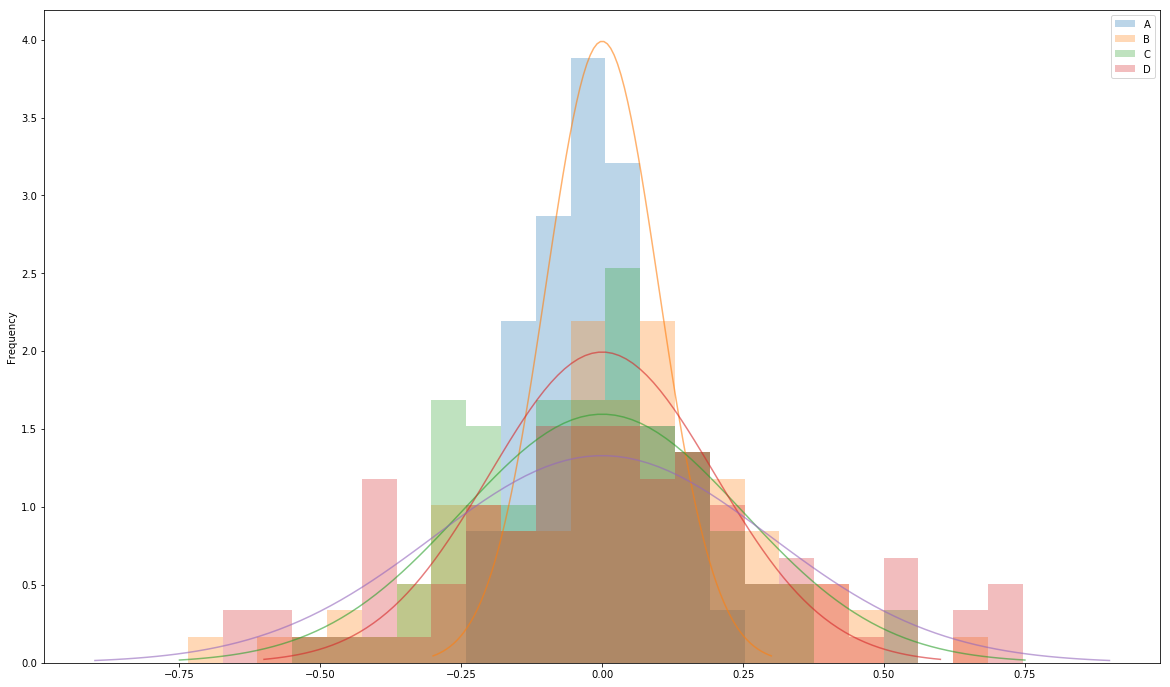

In [6]:
colors = ["C1", "C2", "C3", "C4"]
fig, ax = plt.subplots(figsize=(20,12))
df.plot.hist(bins=24, ax=ax, alpha=0.3, normed=True)
for col, dev, color in zip(cols, devs, colors):
    x = np.linspace(- 3*dev, 3*dev, 100)
    ax.plot(x, norm.pdf(x, 0, dev), c=color, alpha = 0.6)
plt.show()

Now we have our "inspected parts". Let's have a look at the variation on the volume of the part have on the assembly

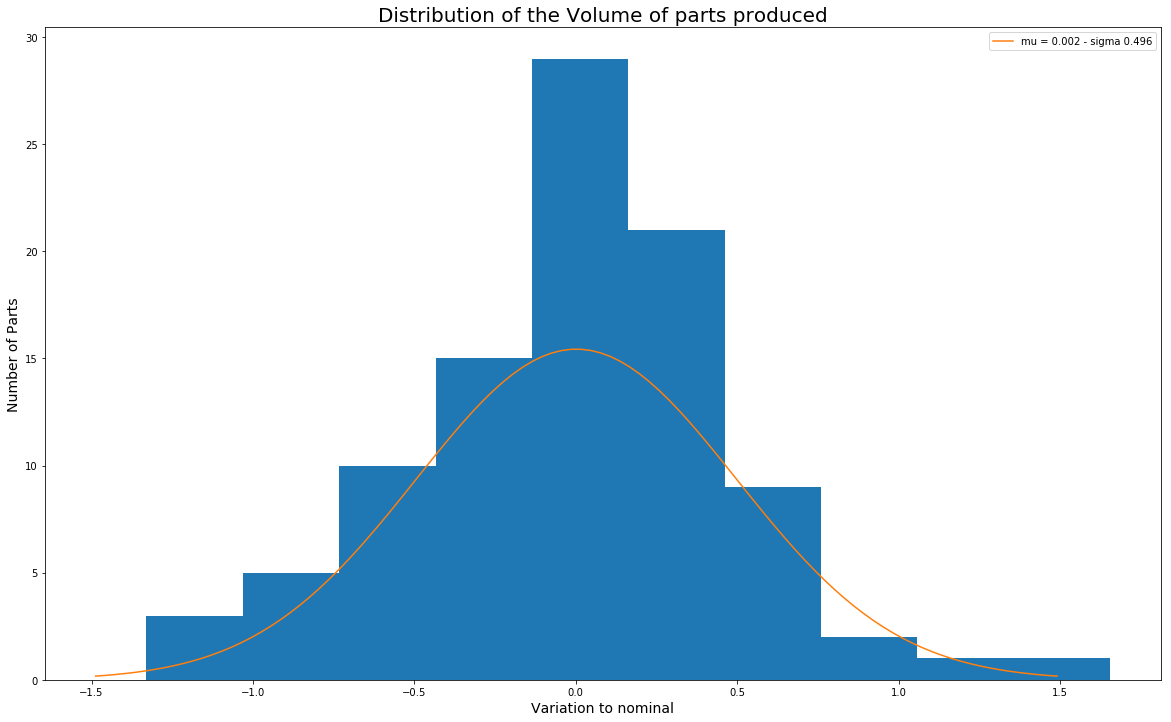

In [7]:
total = df.sum(axis=1)
sigma = total.std()
mu = total.mean()
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
bins = 10
fig, ax = plt.subplots(figsize=(20,12))
ax.hist(total, bins=bins)
ax.plot(x, 2*nb_parts/bins*norm.pdf(x, mu, sigma), label = "mu = {:.3f} - sigma {:.3f}".format(mu, sigma))
ax.legend()
ax.set_title("Distribution of the Volume of parts produced", fontsize=20)
ax.set_ylabel("Number of Parts", fontsize=14)
ax.set_xlabel("Variation to nominal", fontsize=14)
plt.show()

We can see that our Std. Deviation is bigger than all our manufacturing deviation. As they are all centered in zero, we can show that the deviation can be predicted as :
    
\begin{equation*}
Dev = \sqrt{\sum_{i=0}^{N}{devs[i]^{2}}}
\end{equation*}

In [8]:
print("Sigma set :", sigma)
print("Sigma calc :", sum([x**2 for x in devs])**0.5)

Sigma set : 0.49623266020512524
Sigma calc : 0.45


In [9]:
gc.collect()

21877

# Solver

As this problem is NP-complete, we cannot find a solution easily. We can compute the number of arrangement if we consider having 4 differents parts and 96 sample of each parts.

\begin{align}
\ N_{arrangement\:total} & = \prod_{i=0}^{N_{parts}} N_{arrangement\:for\:each\:parts}  \\
\ N_{arrangement\:total} & = \prod_{i=0}^{N_{parts}} N_{sample}! \\
\ N_{arrangement\:total} & = 96!^{4} \\
\ N_{arrangement\:total} & = 96!^{4} \\
\ N_{arrangement\:total} & \approx 9.916779e+149^{4} \\
\ N_{arrangement\:total} & \approx 9.6e599 \\
\end{align}

In reality we can keep one part fixed and this reduce the number of arrangement to $$9.73e449$$

This is definitely impossible to manage. We need to use a Stochastic approach and in this notebook, we will use Genetic Algorithms.

### Definition

#### Population creation

For each generation, we will create new individuals up to a given number of individuals in our population. Everytime we will consider the part D as fixed. All other "parts" will be shuffled.

#### Selection

Each individual will have a fitness score. The best individual (the one with a lowest stdev) will have a fitness of 1  and the worse one with 0. The selection phase will only keep the best individual. The quantity will be based on the selection rate and population size. This is not the best approach as we may end up at a local maximum but the factor are set in order to add at every iteration new fully random elements

#### Crossover

For the crossover, we know the number of items impacted based on the population size and crossover_rate. So we will pick this number of parts 2 by 2 and swap random columns in A, B, C (we don't have to swap D as it is fixed). Those new items will be added to the population

#### Mutation

We randomly select some items based on mutation rate. Those items will mutate as follow :
- Pick a random part in A, B, C
- Pick a random start and stop position
- Shuffle the genome of the part between start and stop position.

## Build

Now we know what to do, let's implement the model.

In [13]:
class Population:
    def __init__(self, population_size = 50, selection_rate = 0.5, crossover_rate = 0.2, mutation_rate=0.05):
        self.population_size = population_size
        self.selection_rate = selection_rate
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []
        self.best = None
        self._scores = None
        
    def fill_population(self, df):
        if isinstance(self.population, np.ndarray):
            self.population = self.population
            
        while len(self.population) < self.population_size:
            ind = Individual(df["D"], df["A"], df["B"], df["C"])
            ind.shuffle()
            self.population.append(ind)
    
    @property
    def fitness(self):
        if self._scores is None:
            scores = np.array([x.score for x in self.population])
            self._scores = 1 - (scores - scores.min())/(scores.max() - scores.min() + 1e-6)
        return self._scores

    def get_best(self):
        best_this_generation = self.population[np.argmax(self.fitness)]
        if self.best is None or best_this_generation.score < self.best.score :
            self.best = best_this_generation
    
    def make_selection(self):
        self.population.sort(key = lambda x:x.score, reverse = True)
        keep_qty = int(self.population_size*self.selection_rate)
        self.population = self.population[:keep_qty]

    def make_crossover(self):
        num_cross = int(len(self.population) * self.crossover_rate)
        idx = np.arange(len(self.population))
        np.random.shuffle(idx)
        idx = idx[:2*num_cross]
        idx = idx.reshape(num_cross, 2)
        for item_a, item_b in idx:
            parent_1 = copy.deepcopy(self.population[item_a])
            parent_2 = copy.deepcopy(self.population[item_b])
            col = np.random.randint(3)
            parent_1.cross(parent_2, col)  # will impact parent 1 and parent 2
            self.population.append(parent_1)
            self.population.append(parent_2)
        
    def make_mutation(self):
        for indiv in self.population:
            if np.random.random() < self.mutation_rate:
                parent = copy.deepcopy(indiv)
                parent.mutate()
                self.population.append(parent)
        
    def make_generation(self, df):
        self._scores = None
        self.fill_population(df)
        self.get_best()
        self.make_selection()
        self.make_crossover()
        self.make_mutation()
        
    def __len__(self):
        return len(self.population)

In [14]:
class Individual:
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.len = len(self.a)
        self.mapping = {0: self.a, 1: self.b, 2: self.c, 3: self.d}
        self._score = None
        
    @property
    def score(self):
        if self._score is None:
            _, self._score = self.get_params()
        return self._score
    
    def get_params(self):
        total = self.a.values + self.b.values + self.c.values + self.d.values
        return total.mean(), total.std()
    
    def shuffle(self):
        self.d = self.d # keep cores ordered
        self.a = self.a.iloc[self.get_shuffled_index(self.len)]
        self.b = self.b.iloc[self.get_shuffled_index(self.len)]
        self.c = self.c.iloc[self.get_shuffled_index(self.len)]
        
    def get_shuffled_index(self, n):
        order = np.arange(n)
        np.random.shuffle(order)
        return order
        
    def cross(self, other, col):
        # swap feature from 2 objects
        self.mapping[col], other.mapping[col] = other.mapping[col], self.mapping[col]
        
    def mutate(self):
        col = np.random.randint(4)
        t1 = self.mapping[col].keys()
        r = np.random.randint(self.len, size=2)
        mini, maxi = min(r), max(r)
        a = self.mapping[col].keys().tolist()[:mini]
        b = self.mapping[col].keys().tolist()[mini:maxi]
        c = self.mapping[col].keys().tolist()[maxi:]
        np.random.shuffle(b)
        self.mapping[col] = self.mapping[col].iloc[a+b+c]

Just to verify it, we can run one generation:

In [15]:
pop = Population(population_size=50)
pop._scores = None
print("Population before fill : ", len(pop))
pop.fill_population(df)
print("Population after fill : ", len(pop))
pop.get_best()
pop.make_selection()
print("Population after selection : ", len(pop))
pop.make_crossover()
print("Population after crossover : ", len(pop))
pop.make_mutation()
print("Population after mutation : ", len(pop))

Population before fill :  0
Population after fill :  50
Population after selection :  25
Population after crossover :  35
Population after mutation :  36


With a starting population of 50 individuals, we keep the 25 best ones.

On those 25 parts, we create 10 new individuals based on crossover. 

On those 35 parts, we create sometime a new individual based on mutation.

In [16]:
pop = Population(population_size=50)
best_score = [sigma]
pop = Population(population_size=50)
for gen in tqdm.tqdm(range(1, 3000)):
    pop.make_generation(df)
    best_score.append(pop.best.score)
#     print("Gen {} : {:.3f} (Population = {})".format(gen, pop.best.score, len(pop)))
gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████| 2999/2999 [00:15<00:00, 191.07it/s]


24

# Result

Now let's compare the best arrangement we have after 3000 generations compare to the result without shuffle. To do so we can plot the best element over all generations

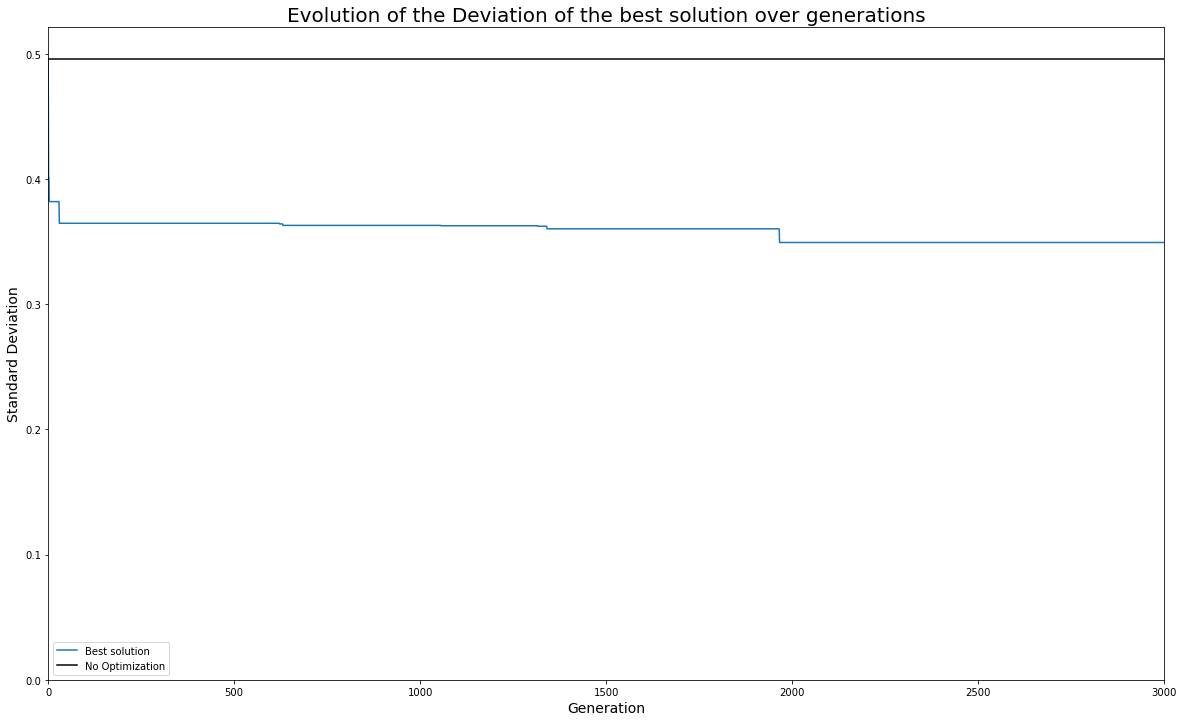

In [33]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(best_score, label="Best solution")
ax.axhline(y=sigma, label="No Optimization", c="k")
ax.set_ylim(0, sigma*1.05)
ax.set_xlim(0, len(best_score))
ax.legend(loc=3)
ax.set_title("Evolution of the Deviation of the best solution over generations", fontsize=20)
ax.set_ylabel("Standard Deviation", fontsize=14)
ax.set_xlabel("Generation", fontsize=14)
plt.show()

We can also plot both distribution

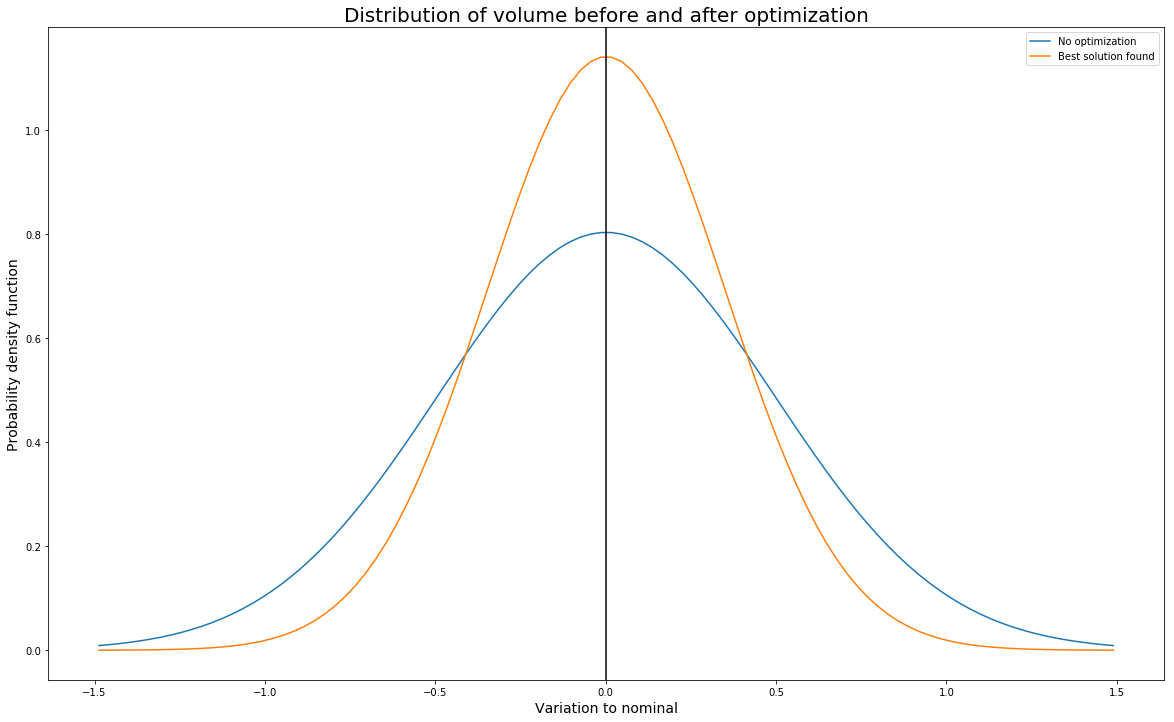

In [36]:
total = df.sum(axis=1)

mu, std = total.mean(), total.std()
new_mu, new_std = pop.best.get_params()

x = np.linspace(mu-3*sigma, mu+3*sigma, 100)

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(x, norm.pdf(x, mu, sigma), label="No optimization")
ax.plot(x, norm.pdf(x, new_mu, new_std), label="Best solution found")
ax.axvline(c="k")
ax.legend(loc=0)
ax.set_title("Distribution of volume before and after optimization", fontsize=20)
ax.set_ylabel("Probability density function", fontsize=14)
ax.set_xlabel("Variation to nominal", fontsize=14)
plt.show()

But the best thing to do is to look at the tolerance in which we can get all parts in. To do so, we should compare old distribution to new one on the same range.

In [61]:
old_cov = []
new_cov = []
dx = 0.05
x = np.arange(0, 1.05, dx)
for covered in x:
    old_range = covered
    low = (1-old_range)/2
    high = (1+old_range)/2
    lim_low = norm.ppf(low, mu, sigma)
    lim_high = norm.ppf(high, mu, sigma)
    new_range = norm.cdf(lim_high, new_mu, new_std) - norm.cdf(lim_low, new_mu, new_std)
    old_cov.append(old_range)
    new_cov.append(new_range)

In [62]:
coverage = 0.9
old_y = old_cov[int(np.argwhere(x==coverage))]
new_y = new_cov[int(np.argwhere(x==coverage))]
print("The range to cover {:.1f}% of parts w/o optimization allow a cover of {:.1f}% with optimization".format(coverage*100, new_y*100))

The range to cover 90.0% of parts w/o optimization allow a cover of 98.1% with optimization


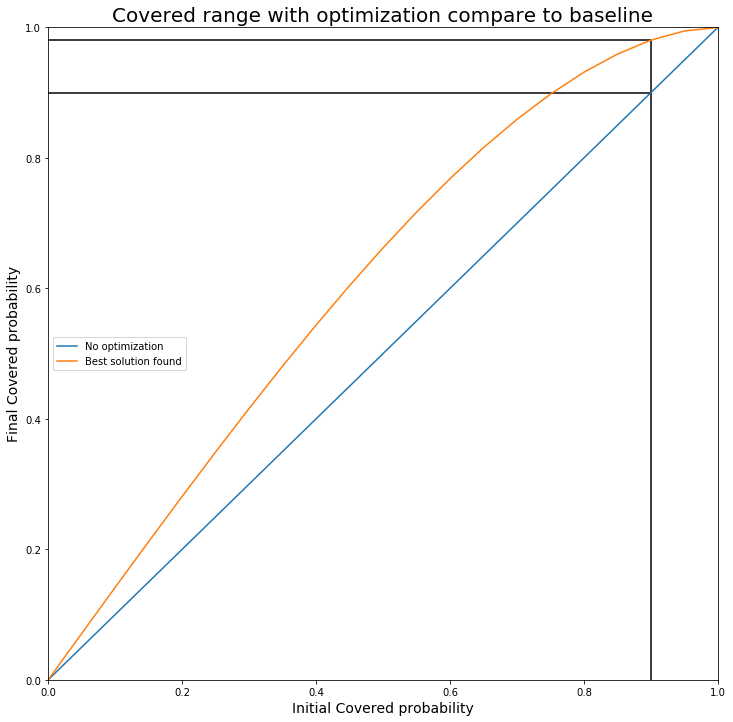

In [63]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x, old_cov, label="No optimization")
ax.plot(x, new_cov, label="Best solution found")
ax.legend(loc=6)
ax.set_title("Covered range with optimization compare to baseline", fontsize=20)
ax.set_ylabel("Final Covered probability", fontsize=14)
ax.set_xlabel("Initial Covered probability", fontsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.vlines(coverage, 0, new_y)
ax.hlines(old_y, 0, coverage)
ax.hlines(new_y, 0, coverage)
plt.show()

We can estimate how good the optimization is by computing the area between orange and blue. If the model is perfect, the area is 0.5, if the model is random, the area is 0 (same as ROC curve), and we have :

In [65]:
perf = 2*(sum(new_cov)*dx - .5)
print("The new model is {:.1f}% more performant".format(perf*100))

The new model is 26.8% more performant


# Stability

So far we made the training on 1 dataset. Maybe we had luck/no luck and the performance is a lot worse/better. To do so, I ran few hunderdth simulations with random dataset everytime. Let's look at the distribution of the result.

In [7]:
import glob
import os
import pickle

To have multiprocessing, I saved every list as a pickle file. Let's load them and store in a dataframe

In [15]:
summary = {}
for path in glob.glob("F:/data/stack_arrangement/*.pkl"):
    with open(path, 'rb') as f:
        res = pickle.load(f)
    name = os.path.basename(path)[:-4]
    summary[name] = res
summary = pd.DataFrame(summary)

In [16]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 556 entries, 0045n3nvy2u9683yl229yspwx882sk to zyudtebehtho3fv2dvu93kqo79nfgd
dtypes: float64(556)
memory usage: 12.7 MB


So we have 556 simulations of 3000 generations. Let's see how they are distributed

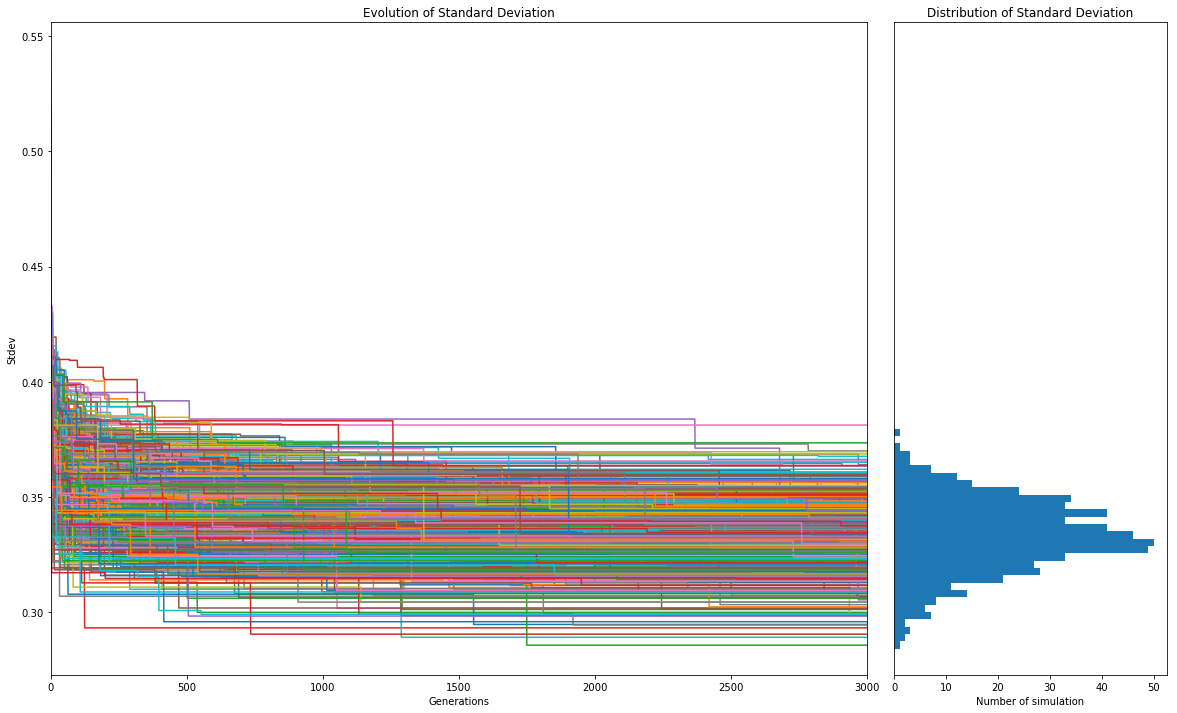

In [79]:
count, y = np.histogram(summary.iloc[-1].values, bins=30)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1], 'wspace':0.05},  figsize=(20,12))
summary.plot(ax=ax, legend=False)
ax2.barh(y[:-1], count, height=y[1]-y[0])
ax2.set_ylim(ax.get_ylim())

ax.set_title("Evolution of Standard Deviation")
ax2.set_title("Distribution of Standard Deviation")
ax.set_ylabel("Stdev")
ax2.set_yticks([])
ax.set_xlabel("Generations")
ax2.set_xlabel("Number of simulation")

plt.show()

Previously we plot the result based on raw values. As they dont have the same starting point due to randomness, let's normalize every columns to 1.

In [60]:
def normalize(x):
    x0 = x[x.first_valid_index()]
    return x/x0

summary_normed = summary.apply(lambda x: normalize(x), axis=0)

In [61]:
summary_normed.head()

,0045n3nvy2u9683yl229yspwx882sk,02axjx12t1j9ebixgx4bwd9b2uk3mn,08bcdjg6h3g2xuszorclke9ofv0qw4,09n3ckq4ejksfu41rezyxu63ekiuhx,0ah7g0ras7ycxj7ynb222gkwhc1mdi,0d7b70hs72pe8t2e9o0438iu9jtxbv,0ekq0kp9o1uvoy3p5fy6m79i0xq0s0,0ft9if1riqm2ylm7d2lcq8hyn9cntq,0g4yplloftses4ujgaa0rssc1ba10t,0ien44va4ihrr7c42y3etnp9lndwj0,...,z4x0lqudp0wq6y65m0h54yfskxm82s,zblyzf489jwmx5qqp3hhchh9bp3045,zd9v7tzl69fqcj81h7jugm01mt4vnm,zdbm1zfrdo69g48h892etmc3sdl3vx,zmf1zwdk3bqxd0reabggnnokev8ynf,zr03pco95o2uf0qknzdns75dcw53fc,ztkdd3n5mh4duookrec7z1si0pl11a,ztrdz7t9r7byk316x16v50714w42hy,zuhlrchuf8xvaigtwlmirpscqy5zfd,zyudtebehtho3fv2dvu93kqo79nfgd
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.835682,0.867811,0.804765,0.912283,0.880431,0.896918,0.889865,0.816187,0.891625,0.726096,...,0.825449,0.967784,0.874451,0.896896,0.917659,0.889333,0.761332,0.849118,0.880824,0.930452
2,0.835682,0.867811,0.804765,0.912283,0.873592,0.896918,0.889865,0.816187,0.891625,0.726096,...,0.825449,0.967784,0.874451,0.896896,0.917659,0.889333,0.761332,0.849118,0.880824,0.924804
3,0.835682,0.867811,0.785273,0.912283,0.873592,0.896918,0.889865,0.816187,0.891625,0.726096,...,0.825449,0.945574,0.874451,0.896896,0.917659,0.889333,0.761332,0.849118,0.866197,0.924804
4,0.835682,0.867811,0.785273,0.902078,0.873592,0.896918,0.889865,0.816187,0.891625,0.726096,...,0.825449,0.901612,0.874451,0.896896,0.917659,0.889333,0.761332,0.802500,0.866197,0.874235


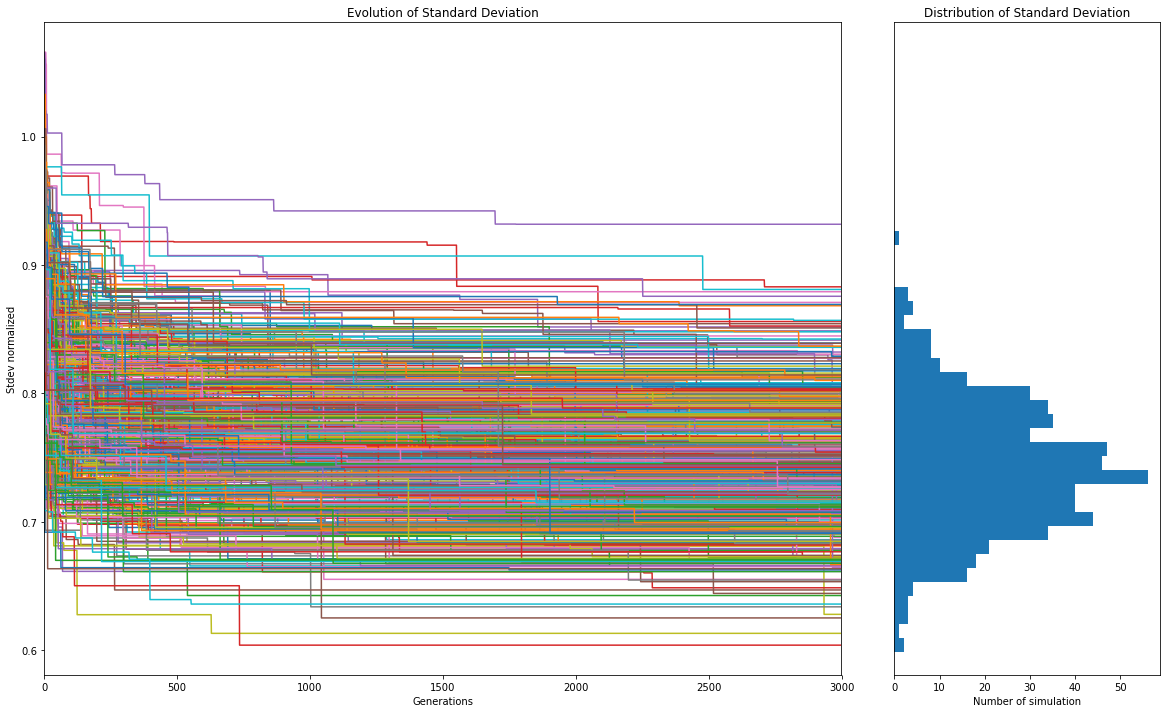

In [78]:
count, y = np.histogram(summary_normed.iloc[-1].values, bins=30)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1], 'wspace':0.05},  figsize=(20,12))
summary_normed.plot(ax=ax, legend=False)
ax2.barh(y[:-1], count, height=y[1]-y[0])
ax2.set_ylim(ax.get_ylim())

ax.set_title("Evolution of Standard Deviation")
ax2.set_title("Distribution of Standard Deviation")
ax.set_ylabel("Stdev normalized")
ax2.set_yticks([])
ax.set_xlabel("Generations")
ax2.set_xlabel("Number of simulation")
plt.show()

In [74]:
mu, sigma = summary_normed.iloc[-1].mean(), summary_normed.iloc[-1].std()
lim095 = (1-norm.ppf(0.95, mu, sigma))*100
lim005 = (1-norm.ppf(0.05, mu, sigma))*100
lim68_minus = (1-(mu-sigma))*100
lim68_plus = (1-(mu+sigma))*100
lim95_minus = (1-(mu-2*sigma))*100
lim95_plus = (1-(mu+2*sigma))*100
print("As a baseline, we can see that this simple fast solution allow a reduction of the Stdev of: \n"
      "- at least {:.1f}% in 95% of cases\n"
      "- more than {:.1f}% in 5% of cases\n"
      "- 68% of cases, the gain will be between {:.1f}% and {:.1f}%\n"
      "- 95% of cases, the gain will be between {:.1f}% and {:.1f}%"
      "".format(lim095, lim005, lim68_minus, lim68_plus, lim95_minus, lim95_plus))

As a baseline, we can see that this simple fast solution allow a reduction of the Stdev of: 
- at least 17.1% in 95% of cases
- more than 33.4% in 5% of cases
- 68% of cases, the gain will be between 30.2% and 20.3%
- 95% of cases, the gain will be between 35.2% and 15.3%


# How to organize the assembly

Of course now we have to be able to know which part goes whit which part and as we store a index for every part we can now reconstruct the dataframe from each series.

In [29]:
arrangement = pd.DataFrame({
    "A" : pop.best.a.keys(), 
    "B" : pop.best.b.keys(), 
    "C" : pop.best.c.keys(), 
    "D" : pop.best.d.keys()
})

In [30]:
arrangement.head()

,A,B,C,D
0,8,67,1,0
1,46,7,18,1
2,38,53,60,2
3,45,46,39,3
4,18,83,41,4


And that's it ! We know that the best solution found after 3000 generation is found by using the 8th part A assemble with 67th part B, 1st part C and D part 0 (as previously explianed, D are not shuffled)

# Conclusion

In this Notebook, I just wanted to check how good we good improve an assembly by taking in consideration manufacturing variability. Of course this algorithm is now able to know if it's the best solution but at least in 15seconds, we are able to find a mix to reduce the variation windows by 26%. In a range of 90% of parts, we are now able to fit 98 % of parts. 

Maybe a better way to do selection, crossover and mutation may help to converge faster but even if we let it run one minute, it's a huge improvement.